In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Preprocessing and Visualisation

In [2]:
df = pd.read_csv("clean-dirty-metadata.csv",sep=';')
df = df.drop(['source','x_lat','y_lon','annotation_path'],axis=1)
df["label"] = (df["label"] == "clean").astype(int)
df

,image_path,split,label
0,clean-dirty-garbage-containers/train/clean/001...,train,1
1,clean-dirty-garbage-containers/train/clean/001...,train,1
2,clean-dirty-garbage-containers/train/clean/001...,train,1
3,clean-dirty-garbage-containers/train/clean/001...,train,1
4,clean-dirty-garbage-containers/train/clean/001...,train,1
...,...,...,...
3407,clean-dirty-garbage-containers/test/dirty/e8e1...,test,0
3408,clean-dirty-garbage-containers/test/dirty/f02b...,test,0
3409,clean-dirty-garbage-containers/test/dirty/f29b...,test,0
3410,clean-dirty-garbage-containers/test/dirty/fc02...,test,0


In [3]:
IMG_WIDTH=32
IMG_HEIGHT=32

#get pathname and convert the image into the right shape
df["images"]=""
for i in range(len(df)) :
    im = cv2.imread(df["image_path"][i].partition("/")[2], cv2.COLOR_BGR2GRAY)
    image = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image)
    image = image.astype('float32')
    image /= 255 
    df["images"][i]=image.astype(float)
    

In [4]:
'''# to have a smaller dataset to work with
from sklearn.utils import shuffle
df = shuffle(df)
df1 = df[:200]
df1
'''
# split into train and test
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

#keep interesting column
train_df = df_train.drop(['image_path','split'],axis=1)
test_df = df_test.drop(['image_path','split'],axis=1)

<AxesSubplot:ylabel='count'>

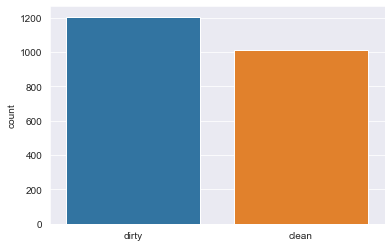

In [5]:
#visualisation to see if my dataset is balance
l = []
for i in df_train.label:
    if(i == 0):
        l.append("clean")
    else:
        l.append("dirty")
sns.set_style('darkgrid')
sns.countplot(l)

In [6]:
#Convert the target arrays to one-hot encodings
'''from keras.utils.np_utils import to_categorical
y_train = tf.keras.utils.to_categorical(
    train_df['label'], num_classes=None, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    test_df['label'], num_classes=None, dtype='float32'
)'''
#one or the other I test
y_train = np.asarray(train_df['label']).astype('float32').reshape((-1,1))
y_test = np.asarray(test_df['label']).astype('float32').reshape((-1,1))

In [7]:
#convert to numpy array 
#!!! suppose to be the same for test but there is a bug and I will deal with it later(tired!!)
train = []
for i in range(len(train_df)):
    train.append(train_df['images'][i])
x_train = np.array(train)

test = []
for index, row in test_df.iterrows():
    test.append(row['images'])
x_test = np.array(test)

In [8]:
print("Shape of training data", x_train.shape)
print("\nShape of test data", x_test.shape)

Shape of training data (2217, 32, 32, 3)

Shape of test data (1195, 32, 32, 3)


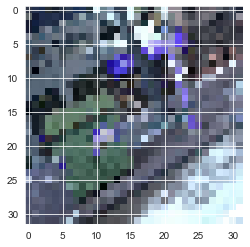

In [9]:
plt.imshow(x_train[630]) #example

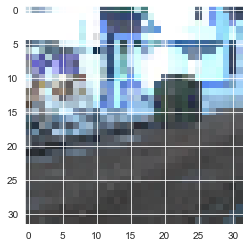

In [10]:
plt.imshow(x_test[61]) #example

## First Naive model

In [11]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 13, 13, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                    

In [12]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5)

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(0.1*x_train, 0.1*y_train),callbacks=es
)

Epoch 1/50
35/35 [==============================] - 5s 56ms/step - loss: 0.6865 - accuracy: 0.5453 - val_loss: 0.6849 - val_accuracy: 0.3820
Epoch 2/50
35/35 [==============================] - 1s 40ms/step - loss: 0.6619 - accuracy: 0.6148 - val_loss: 0.6851 - val_accuracy: 0.3194
Epoch 3/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6317 - accuracy: 0.6468 - val_loss: 0.7157 - val_accuracy: 0.1534
Epoch 4/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6269 - accuracy: 0.6604 - val_loss: 0.6455 - val_accuracy: 0.4263
Epoch 5/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6104 - accuracy: 0.6694 - val_loss: 0.7122 - val_accuracy: 0.1940
Epoch 6/50
35/35 [==============================] - 1s 39ms/step - loss: 0.5995 - accuracy: 0.6797 - val_loss: 0.6731 - val_accuracy: 0.3433
Epoch 7/50
35/35 [==============================] - 1s 39ms/step - loss: 0.6035 - accuracy: 0.6829 - val_loss: 0.7284 - val_accuracy: 0.1159
Epoch 8/50
35

## Predictions

In [13]:
y_pred = model.predict(x_test)
print(y_pred)

[[0.77269495]
 [0.76979065]
 [0.7700156 ]
 ...
 [0.68137354]
 [0.81017876]
 [0.5543243 ]]


clean street by [56.5] % because the prediction is = [0.435]


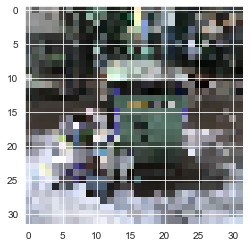

In [14]:
plt.imshow(x_test[1110])
pred = np.round(y_pred[1110],decimals=3)
print('clean street by', np.abs(100 - 100*pred),'%','because the prediction is =',pred)

clean street by [22.699997] % [0.773]


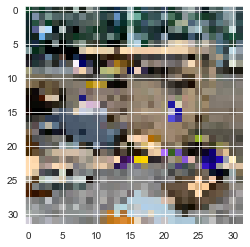

In [15]:
plt.imshow(x_test[1100])
pred = np.round(y_pred[61],decimals=3)
print('clean street by', np.abs(100 - 100*pred),'%',pred)

## Evaluation the result

In [16]:
#change y_pred to binary array
for i in range(len(y_pred)):
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[285, 310],
       [ 34, 566]], dtype=int64)

In [18]:
print('Thats mean that we have', cm[0,0], 'true positive', cm[0,1], 'false negative', cm[1,0], 'false positive and', cm[1,1], 'true negative, well done!')

Thats mean that we have 285 true positive 310 false negative 34 false positive and 566 true negative, well done!


In [19]:
#Accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, y_pred))
# Recall
from sklearn.metrics import recall_score
print('recall score',recall_score(y_test, y_pred))
# Precision
from sklearn.metrics import precision_score
print('precision score',precision_score(y_test, y_pred))
from sklearn.metrics import f1_score
print('f1 score',f1_score(y_test, y_pred))

accuracy score 0.7121338912133891
recall score 0.9433333333333334
precision score 0.6461187214611872
f1 score 0.7669376693766937


In [20]:
y_pred==1
y_pred==0

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [21]:
y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

(188, 250, 3)

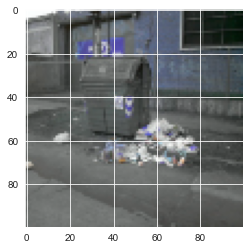

In [22]:
imgh = 100
imgw = 100
im = cv2.imread(df["image_path"][df.shape[0]-1].partition("/")[2], cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.resize(im, (imgh, imgw)))
im.shape

In [23]:
df

,image_path,split,label,images
0,clean-dirty-garbage-containers/train/clean/001...,train,1,"[[[0.08235294371843338, 0.0784313753247261, 0...."
1,clean-dirty-garbage-containers/train/clean/001...,train,1,"[[[0.7254902124404907, 0.6901960968971252, 0.6..."
2,clean-dirty-garbage-containers/train/clean/001...,train,1,"[[[0.7098039388656616, 0.6980392336845398, 0.6..."
3,clean-dirty-garbage-containers/train/clean/001...,train,1,"[[[0.7647058963775635, 0.7529411911964417, 0.7..."
4,clean-dirty-garbage-containers/train/clean/001...,train,1,"[[[0.8352941274642944, 0.8274509906768799, 0.8..."
...,...,...,...,...
3407,clean-dirty-garbage-containers/test/dirty/e8e1...,test,0,"[[[0.95686274766922, 0.9490196108818054, 0.925..."
3408,clean-dirty-garbage-containers/test/dirty/f02b...,test,0,"[[[0.5843137502670288, 0.5098039507865906, 0.4..."
3409,clean-dirty-garbage-containers/test/dirty/f29b...,test,0,"[[[0.10196078568696976, 0.21568627655506134, 0..."
3410,clean-dirty-garbage-containers/test/dirty/fc02...,test,0,"[[[0.9960784316062927, 0.9019607901573181, 0.7..."


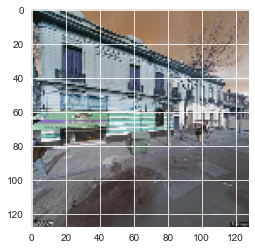

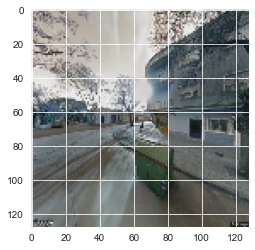

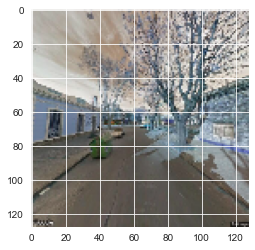

'\nim = cv2.resize(cv2.imread(df["image_path"][df.label==1].iloc[0].partition("/")[2], cv2.COLOR_BGR2GRAY),(100,100))\nplt.imshow(im)\nplt.show()\n'

In [146]:
a = 0
for i in df["image_path"][df.label==1]:
    im = cv2.resize(cv2.imread(i.partition("/")[2], cv2.COLOR_BGR2GRAY),(128,128))
    plt.imshow(im)
    plt.show()
    a = a+1
    if a ==3 : break

"""
im = cv2.resize(cv2.imread(df["image_path"][df.label==1].iloc[0].partition("/")[2], cv2.COLOR_BGR2GRAY),(100,100))
plt.imshow(im)
plt.show()
"""

In [64]:
len(df["image_path"][df.label==1])

1806

In [147]:
cleanScenes = np.array([cv2.resize(cv2.imread(i.partition("/")[2], cv2.COLOR_BGR2GRAY),(128,128)) for i in df["image_path"][df.label==1]])
dirtyScenes = np.array([cv2.resize(cv2.imread(i.partition("/")[2], cv2.COLOR_BGR2GRAY),(128,128)) for i in df["image_path"][df.label==0]])

In [148]:
cleanScenes = (cleanScenes - 127.5) / 127.5
dirtyScenes = (dirtyScenes - 127.5) / 127.5

In [111]:
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam

In [ ]:
"""
git clone https://www.github.com/keras-team/keras-contrib.git
cd keras-contrib
sudo ~/anaconda3/envs/tensorflow_p36/bin/python setup.py install
"""

In [73]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [124]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [125]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

In [126]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [127]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [128]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [129]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [130]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [131]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [132]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [122]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        if(i%100==0):print(i,"out of",n_steps)
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)

In [149]:
datasetTEST = [cleanScenes[:20],dirtyScenes[:20]]

In [150]:
print('Loaded', datasetTEST[0].shape, datasetTEST[1].shape)
# define input shape based on the loaded dataset
image_shape = datasetTEST[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

Loaded (20, 128, 128, 3) (20, 128, 128, 3)


In [141]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from matplotlib import pyplot

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, datasetTEST)

0 out of 2000
>1, dA[1.158,0.605] dB[0.945,0.933] g[17.722,17.804]
>2, dA[2.717,2.600] dB[5.050,1.036] g[16.488,15.517]
>3, dA[15.234,0.711] dB[4.905,12.117] g[36.078,16.025]
>4, dA[6.671,0.936] dB[1.124,0.752] g[16.871,17.413]
>5, dA[5.848,0.879] dB[1.670,1.823] g[17.844,18.102]
>6, dA[1.217,9.201] dB[5.224,0.994] g[16.301,29.050]
>7, dA[3.268,2.738] dB[3.219,1.106] g[15.952,18.530]
>8, dA[2.862,1.191] dB[2.211,1.324] g[14.531,16.001]
>9, dA[0.857,0.961] dB[3.800,2.759] g[14.261,15.519]
>10, dA[0.669,0.819] dB[1.872,1.151] g[13.168,13.693]
>11, dA[0.767,1.037] dB[1.525,3.791] g[18.178,13.910]
>12, dA[3.896,1.562] dB[1.488,3.897] g[18.600,13.943]
>13, dA[2.523,0.980] dB[0.598,1.549] g[14.348,14.371]
>14, dA[2.022,3.715] dB[0.500,0.549] g[12.441,15.473]
>15, dA[2.625,1.661] dB[0.430,1.133] g[12.078,11.781]
>16, dA[0.941,0.940] dB[0.975,1.189] g[9.826,10.365]
>17, dA[1.185,0.755] dB[1.414,0.769] g[11.909,11.531]
>18, dA[0.775,0.613] dB[0.529,0.636] g[10.537,10.002]
>19, dA[0.764,0.312] d